In [ ]:

# Necessary Imports
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
import math


# Global list to store clicked points
clicked_points = []
img_path = "Micromouse_continuous_2.jpg"   # <-- replace with your path
cell_size = 60                          # pixels per cell (tweak for resolution)
show_labels = True         

start_x = 0
start_y = 2
end_x = 8
end_y = 3

In [85]:
def mouse_callback(event, x, y, flags, param):
    global clicked_points
    if event == cv2.EVENT_LBUTTONDOWN:
        clicked_points.append((x, y))
        print(f"Point {len(clicked_points)}: {x}, {y}")

        # Draw a small circle on the clicked point
        img_copy = param.copy()
        for pt in clicked_points:
            cv2.circle(img_copy, pt, 5, (0, 0, 255), -1)
        cv2.imshow("Select Points", img_copy)

        # If 4 points clicked, close window
        if len(clicked_points) == 4:
            cv2.destroyAllWindows()

In [86]:
# Load image

img = cv2.imread(img_path)

cv2.imshow("Select Points", img)
cv2.setMouseCallback("Select Points", mouse_callback, img)

print("Click the 4 reference points in order: (0,0), (0,8), (8,0), (8,8)")

# Loop until 4 points selected
while True:
    cv2.waitKey(1)  # short delay so window stays responsive
    if len(clicked_points) == 4:
        break

cv2.destroyAllWindows()

# Continue with transform
cell_size = 50
pts_src = np.array(clicked_points, dtype=np.float32)
# Add half cell padding to center the grid properly
padding = cell_size // 2
pts_dst = np.array([
    [padding, padding],
    [padding, 8 * cell_size + padding],
    [8 * cell_size + padding, padding],
    [8 * cell_size + padding, 8 * cell_size + padding]
], dtype=np.float32)

matrix = cv2.getPerspectiveTransform(pts_src, pts_dst)
# Increase canvas size to accommodate padding
canvas_size = 9 * cell_size 
warped = cv2.warpPerspective(img, matrix, (canvas_size, canvas_size))

# Transform the clicked points to the warped perspective
clicked_points_array = np.array(clicked_points, dtype=np.float32)
# Reshape for cv2.perspectiveTransform (needs shape: (1, n, 2))
clicked_points_reshaped = clicked_points_array.reshape(1, -1, 2)
transformed_points = cv2.perspectiveTransform(clicked_points_reshaped, matrix)
# Reshape back to (n, 2)
transformed_points = transformed_points.reshape(-1, 2)

# Create a copy of the warped image for overlay
warped_overlay = warped.copy()

# Draw the transformed points on the warped image
colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (255, 255, 0)]  # Red, Green, Blue, Yellow
labels = ["(0,0)", "(0,8)", "(8,0)", "(8,8)"]

for i, (point, color, label) in enumerate(zip(transformed_points, colors, labels)):
    x, y = int(point[0]), int(point[1])
    
    # Draw circle at the point
    cv2.circle(warped_overlay, (x, y), 8, color, -1)
    cv2.circle(warped_overlay, (x, y), 10, (255, 255, 255), 2)  # White border
    
    # Add text label
    cv2.putText(warped_overlay, label, (x + 15, y - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    cv2.imshow("Warped Grid with Points", warped_overlay)
cv2.waitKey(0)
cv2.destroyWindow("Warped Grid with Points")
cv2.waitKey(1)  # Force processing of destroy event
cv2.waitKey(1)

print("Transformed points:")
for i, (original, transformed, label) in enumerate(zip(clicked_points, transformed_points, labels)):
    print(f"{label}: Original {original} -> Transformed ({transformed[0]:.1f}, {transformed[1]:.1f})")


Click the 4 reference points in order: (0,0), (0,8), (8,0), (8,8)
Point 1: 1527, 357
Point 2: 3001, 385
Point 3: 1543, 1806
Point 4: 2961, 1842
Transformed points:
(0,0): Original (1527, 357) -> Transformed (25.0, 25.0)
(0,8): Original (3001, 385) -> Transformed (25.0, 425.0)
(8,0): Original (1543, 1806) -> Transformed (425.0, 25.0)
(8,8): Original (2961, 1842) -> Transformed (425.0, 425.0)


In [87]:
import cv2
import numpy as np

threshold = 160
mask = cv2.threshold(cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY), threshold, 255, cv2.THRESH_BINARY)[1]

edited_mask = mask.copy()

# Mouse callback
drawing = False
radius = 10   # brush size

def draw(event, x, y, flags, param):
    global drawing, edited_mask
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        cv2.circle(edited_mask, (x, y), radius, (255, 255, 255), -1)

    elif event == cv2.EVENT_MOUSEMOVE and drawing:
        cv2.circle(edited_mask, (x, y), radius, (255, 255, 255), -1)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False

cv2.namedWindow("Edit Mask")
cv2.setMouseCallback("Edit Mask", draw)

# Main loop to refresh continuously
while True:
    cv2.imshow("Edit Mask", edited_mask)
    key = cv2.waitKey(1) & 0xFF

    if key == ord('q'):  # press 'q' to quit
        mask = edited_mask.copy()
        break
    elif key == ord('s'):  # press 's' to save
        mask = edited_mask.copy()

cv2.destroyAllWindows()


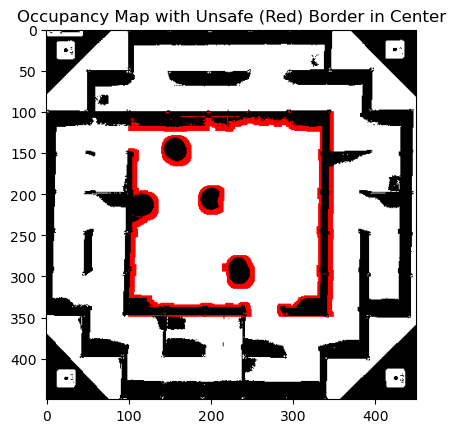

In [88]:
unsafe_kernel_size = 4
unsafe_iterations = 3

# Create binary obstacle map: 1 where black, 0 elsewhere
obstacles = (mask == 0).astype(np.uint8)

# Create kernel and dilate obstacles
kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8)
dilated = cv2.dilate(obstacles, kernel, iterations=unsafe_iterations)

# Border = dilated - original
border = dilated - obstacles

# Convert original image to RGB for colored display
image_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

# Define rectangle slice (rows 100:350, columns 100:350)
rows = slice(100, 350)
cols = slice(100, 350)

# Apply red only inside the rectangle where border==1
image_rgb[rows, cols][border[rows, cols] == 1] = [255, 0, 0]

# Display
plt.imshow(image_rgb)
plt.title("Occupancy Map with Unsafe (Red) Border in Center")
plt.show()


In [89]:
# Task 2.1 (0 marks):  Complete the graph class
import heapq
from collections import deque

class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x,self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}  # node_id -> Node
        self.edges = {}  # node_id -> dict of (neighbor_id -> weight)

    def add_node(self, node_id, x, y):
        if node_id not in self.nodes:
            self.nodes[node_id] = Node(node_id, x, y)
            self.edges[node_id] = {}

    def add_edge(self, node_id1, node_id2, weight):
        if node_id1 in self.nodes and node_id2 in self.nodes:
            self.edges[node_id1][node_id2] = weight
            self.edges[node_id2][node_id1] = weight  # Undirected graph

    def remove_edge(self, node_id1, node_id2):
        if node_id2 in self.edges.get(node_id1, {}):
            del self.edges[node_id1][node_id2]
        if node_id1 in self.edges.get(node_id2, {}):
            del self.edges[node_id2][node_id1]

    def get_nodes(self):
        return list(self.nodes.values())  # returns list of Node objects

    def get_edge_weight(self, node_id1, node_id2):
        return self.edges.get(node_id1, {}).get(node_id2, None)
    
    def bfs_shortest_path(self, start_id, end_id):
        if start_id not in self.nodes or end_id not in self.nodes:
            return None

        visited = set()
        parent = {}
        queue = deque()
        
        visited.add(start_id)
        queue.append(start_id)
        
        while queue:
            current = queue.popleft()
            if current == end_id:
                break
            for neighbor in self.edges.get(current, {}):
                if neighbor not in visited:
                    visited.add(neighbor)
                    parent[neighbor] = current
                    queue.append(neighbor)
        
        # Reconstruct path
        if end_id not in parent and start_id != end_id:
            return None  # No path

        path = [end_id]
        while path[-1] != start_id:
            path.append(parent[path[-1]])
        path.reverse()
        return path
    
    # Dijstra's algorithm class
    def dijkstra_shortest_path(self, start_id, end_id):
        if start_id not in self.nodes or end_id not in self.nodes:
            return None, float('inf')

        dist = {node_id: float('inf') for node_id in self.nodes}
        parent = {}
        dist[start_id] = 0

        heap = [(0, start_id)]  # (distance, node_id)

        while heap:
            current_dist, current = heapq.heappop(heap)
            if current == end_id:
                break

            for neighbor, weight in self.edges.get(current, {}).items():
                new_dist = current_dist + weight
                if new_dist < dist[neighbor]:
                    dist[neighbor] = new_dist
                    parent[neighbor] = current
                    heapq.heappush(heap, (new_dist, neighbor))

        if dist[end_id] == float('inf'):
            return None, float('inf')  # No path
            
        # Reconstruct path
        path = [end_id]
        while path[-1] != start_id:
            path.append(parent[path[-1]])
        path.reverse()

        return path, dist[end_id]       


In [90]:
height, width, _ = image_rgb.shape

def get_node_id(x, y):
    return 9*x + y

def is_obstacle(pixel):
    return (pixel == [0, 0, 0]).all() or (pixel == [255, 0, 0]).all()

# Helper function to check if edge is clear (between two points)
def path_clear(p1, p2):
    # Number of points that is sampled across the line
    num_points = 20 
    xs = np.linspace(p1[0], p2[0], num_points).astype(int)
    ys = np.linspace(p1[1], p2[1], num_points).astype(int)
    for x, y in zip(xs, ys):
        if not (0 <= x < width and 0 <= y < height):
            return False
        pixel = image_rgb[y, x]
        if is_obstacle(pixel):
            return False
    return True

def is_free(x, y):
    if not (0 <= x < width and 0 <= y < height):
        return False
    pixel = image_rgb[y, x]  # Note: y is row, x is col
    return not ((pixel == [0, 0, 0]).all() or (pixel == [255, 0, 0]).all())

In [91]:
# Create the graph and populate with grid intersection nodes
graph = Graph()

length = 9

# Create nodes at each grid intersection
# For an 8x8 cell grid, we have 9x9 intersection points
idx = 0
pos = {}

warped_with_nodes = warped_overlay.copy()

for row in range(length):
    for col in range(length):
        # Calculate the pixel coordinates for this grid intersection
        x = col * cell_size + padding
        y = row * cell_size + padding
        
        # Create unique node ID (you can use various schemes)
        # Using format: "r{row}c{col}" for readability
        node_id = idx
        idx += 1
        # Add node to graph
        graph.add_node(node_id, x, y)
        pos[node_id] = (x, y)
        
# ADD EDGES
for row in range(length):
    for col in range(length):
        # Calculate the pixel coordinates for this grid intersection
        node_id = get_node_id(row, col)
        node_id_right = get_node_id(row, col + 1)
        node_id_down = get_node_id(row + 1, col)
        
        x1 = pos[node_id][0]
        y1 = pos[node_id][1]
        
        if (row < length - 1):
            x2 = pos[node_id_down][0]
            y2 = pos[node_id_down][1]
            pixel = image_rgb[y2, x2]
            if not is_obstacle(pixel) and path_clear((x1, y1), (x2, y2)):
                graph.add_edge(node_id, node_id_down, abs(x2 - x1) + abs(y2 - y1))
                cv2.line(warped_with_nodes, (x1, y1), (x2, y2), (0, 255, 0), 1)
                
        if (col < length - 1):
            x2 = pos[node_id_right][0]
            y2 = pos[node_id_right][1]
            pixel = image_rgb[y2, x2]
            if not is_obstacle(pixel) and path_clear((x1, y1), (x2, y2)):
                graph.add_edge(node_id, node_id_right, abs(x2 - x1) + abs(y2 - y1))
                cv2.line(warped_with_nodes, (x1, y1), (x2, y2), (0, 255, 0), 1)
            
        node_id = idx
        idx += 1
        # Add node to graph
        graph.add_node(node_id, x, y)
        
        




# Draw all intersection points
for node in graph.get_nodes():
    x, y = int(node.x), int(node.y)
    
    # Draw small circles at each intersection
    cv2.circle(warped_with_nodes, (x, y), 3, (255, 255, 255), -1)  # White filled circle
    cv2.circle(warped_with_nodes, (x, y), 4, (0, 0, 0), 1)        # Black border
    
    # Optional: Add node ID labels (might be cluttered)
    # cv2.putText(warped_with_nodes, node.get_ID(), (x-10, y-10), 
    #            cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)

# Highlight the 4 reference corner nodes in different colors
corner_colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (255, 255, 0)]  # Red, Green, Blue, Yellow
corner_nodes = ["r0c0", "r8c0", "r0c8", "r8c8"]

for node_id, color in zip(corner_nodes, corner_colors):
    if node_id in graph.nodes:
        node = graph.nodes[node_id]
        x, y = int(node.x), int(node.y)
        cv2.circle(warped_with_nodes, (x, y), 6, color, -1)
        cv2.circle(warped_with_nodes, (x, y), 8, (255, 255, 255), 2)

cv2.imshow("Grid with All Nodes", warped_with_nodes)
cv2.waitKey(0)
cv2.destroyWindow("Grid with All Nodes")
cv2.waitKey(1)
cv2.waitKey(1)


-1

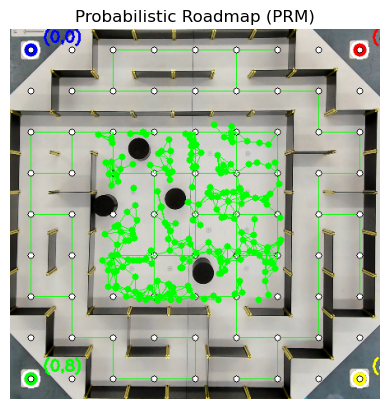

In [92]:
prm_total_nodes_count = 200
prm_connection_radius = 20
i = 0
node_id = idx

prm_image = warped_with_nodes.copy()

while i < prm_total_nodes_count:
    x = random.randint(100, 330)
    y = random.randint(100, 330)

    if not is_free(x, y):
        continue  # Skip invalid location

    # Add node
    graph.add_node(node_id, x, y)
    pos[node_id] = (x, y)
    cv2.circle(prm_image, (x, y), 4, (0, 255, 0), -1)  # Green dot

    # Try to connect to all previous nodes
    for other_id in pos:
        if other_id == node_id:
            continue
        x2, y2 = pos[other_id]
        dist = math.hypot(x - x2, y - y2)
        if dist <= prm_connection_radius and path_clear((x, y), (x2, y2)):
            graph.add_edge(node_id, other_id, dist)
            cv2.line(prm_image, (x, y), (x2, y2), (0, 255, 0), 1)

    node_id += 1
    i += 1
plt.imshow(prm_image)
plt.title("Probabilistic Roadmap (PRM)")
plt.axis("off")
plt.show()



([2, 3, 4, 5, 14, 15, 16, 25, 26, 35, 34, 43, 52, 61, 70, 69, 68, 59, 50, 218, 357, 165, 339, 342, 210, 174, 351, 39, 30, 29, 20, 19, 18, 27, 36, 37, 46, 55, 64, 65, 74, 75], 1730.0783634032064)


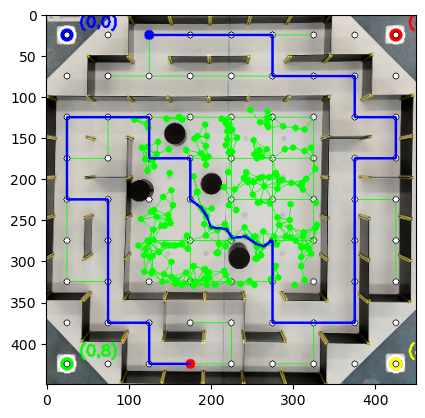

In [93]:
start_id = get_node_id(start_x, start_y)
end_id = get_node_id(end_x, end_y)

route = graph.dijkstra_shortest_path(start_id, end_id)
print(route)
# Display the resulting image
path = route[0]

# --- Draw start point (green) ---
x1_mark, y1_mark = pos[start_id]
cv2.circle(prm_image, (x1_mark, y1_mark), 6, (0, 0, 255), -1)

# --- Draw end point (blue) ---
x2_mark, y2_mark = pos[end_id]
cv2.circle(prm_image, (x2_mark, y2_mark), 6, (255, 0, 0), -1)

if path is not None and len(path) > 1:
    for i in range(len(path) - 1):
        n1 = path[i]
        n2 = path[i+1]
        x1 = pos[n1][0]
        y1 = pos[n1][1]
        x2 = pos[n2][0]
        y2 = pos[n2][1]
        cv2.line(prm_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
        
plt.imshow(prm_image)
plt.show()


In [94]:
print(path)

calc_path = []

for node_id in path:
    calc_path.append(pos[node_id])
    
print(calc_path)

[2, 3, 4, 5, 14, 15, 16, 25, 26, 35, 34, 43, 52, 61, 70, 69, 68, 59, 50, 218, 357, 165, 339, 342, 210, 174, 351, 39, 30, 29, 20, 19, 18, 27, 36, 37, 46, 55, 64, 65, 74, 75]
[(125, 25), (175, 25), (225, 25), (275, 25), (275, 75), (325, 75), (375, 75), (375, 125), (425, 125), (425, 175), (375, 175), (375, 225), (375, 275), (375, 325), (375, 375), (325, 375), (275, 375), (275, 325), (275, 275), (264, 282), (255, 279), (242, 270), (226, 272), (219, 261), (200, 259), (195, 245), (188, 235), (175, 225), (175, 175), (125, 175), (125, 125), (75, 125), (25, 125), (25, 175), (25, 225), (75, 225), (75, 275), (75, 325), (75, 375), (125, 375), (125, 425), (175, 425)]


In [95]:
import math

def compute_movements(points, k):
    """
    points: list of (x, y) pixel coordinates
    k: pixels per meter (scale factor)

    Returns: list of (rotation_deg, forward_dist_m)
    """
    movements = []
    
    # Initial heading: facing north (0, -1) in image coords
    heading = (0, -1)

    for i in range(len(points) - 1):
        x1, y1 = points[i]
        x2, y2 = points[i+1]

        # Compute direction vector from current point to next
        dx = x2 - x1
        dy = y2 - y1

        # Normalize direction vector
        length = math.hypot(dx, dy)
        dir_vec = (dx / length, dy / length)

        # Compute angle between current heading and new direction
        dot = heading[0]*dir_vec[0] + heading[1]*dir_vec[1]
        det = heading[0]*dir_vec[1] - heading[1]*dir_vec[0]
        angle_rad = math.atan2(det, dot)
        angle_deg = math.degrees(angle_rad)

        # Compute forward distance in meters
        forward_dist = length / k

        movements.append((angle_deg, forward_dist))

        # Update heading to new direction
        heading = dir_vec

    return movements


# Example usage
k = 50  # example: 50 pixels per meter

movements = compute_movements(calc_path, k)
for i, (angle, dist) in enumerate(movements):
    print(f"Step {i+1}: Rotate {angle:.2f}°, Forward {dist:.2f} m")
    
print(movements)

Step 1: Rotate 90.00°, Forward 1.00 m
Step 2: Rotate 0.00°, Forward 1.00 m
Step 3: Rotate 0.00°, Forward 1.00 m
Step 4: Rotate 90.00°, Forward 1.00 m
Step 5: Rotate -90.00°, Forward 1.00 m
Step 6: Rotate 0.00°, Forward 1.00 m
Step 7: Rotate 90.00°, Forward 1.00 m
Step 8: Rotate -90.00°, Forward 1.00 m
Step 9: Rotate 90.00°, Forward 1.00 m
Step 10: Rotate 90.00°, Forward 1.00 m
Step 11: Rotate -90.00°, Forward 1.00 m
Step 12: Rotate 0.00°, Forward 1.00 m
Step 13: Rotate 0.00°, Forward 1.00 m
Step 14: Rotate 0.00°, Forward 1.00 m
Step 15: Rotate 90.00°, Forward 1.00 m
Step 16: Rotate 0.00°, Forward 1.00 m
Step 17: Rotate 90.00°, Forward 1.00 m
Step 18: Rotate 0.00°, Forward 1.00 m
Step 19: Rotate -122.47°, Forward 0.26 m
Step 20: Rotate 50.91°, Forward 0.19 m
Step 21: Rotate 16.26°, Forward 0.32 m
Step 22: Rotate -41.82°, Forward 0.32 m
Step 23: Rotate 64.65°, Forward 0.26 m
Step 24: Rotate -51.52°, Forward 0.38 m
Step 25: Rotate 64.34°, Forward 0.30 m
Step 26: Rotate -15.34°, Forward 0.